# Ch10 | DPO: Direct Preference Optimization

---

- **目标：** 理解并实现 DPO，用于模型对齐
- **任务：** 训练模型学会**简洁回复**风格（而非冗长啰嗦）

**为什么选择这个任务？**
- 大多数指令模型倾向于冗长回复
- 风格偏好是 DPO 最擅长的对齐场景
- 效果可量化：回复长度变化
- 训练前后行为差异显著可观测

**设备建议：** GPU 更佳；CPU 适合阅读与小样本演示。

## 内容导览
1. 对齐动机与目标
2. RLHF 细节 vs DPO 优势
3. 偏好数据结构与构造方式
4. DPO 数学推导与直觉
5. 训练与评估：看见风格强度变化
6. 生产级实现：TRL DPOTrainer（可选）

## 为什么需要对齐？

SFT 让模型学会“能回答”，但不保证“回答得好”。常见问题：
- 生成有害内容
- 回答不够有用或过于啰嗦
- 风格、礼貌与事实性偏离用户期望

### 对齐目标
让模型更：
- **有帮助**：给出准确、简洁、可执行的答案
- **诚实**：承认不确定与限制
- **无害**：拒绝危险或不当请求

## RLHF vs DPO

| 方法 | 步骤 | 复杂度 |
|--------|-------|------------|
| **RLHF** | SFT -> 训练奖励模型 -> PPO | 复杂 |
| **DPO** | SFT -> 直接偏好优化 | 简单 |

### RLHF 的关键环节
1. 收集偏好对（prompt, chosen, rejected）
2. 训练奖励模型 `r(x, y)`（pairwise ranking / Bradley-Terry）
3. 用 PPO 在奖励模型上优化，并加入 KL 约束避免偏离参考模型

**挑战：** on-policy 采样成本高、PPO 调参多、训练不稳定，且可能出现 reward hacking。

### DPO 的替代思路
- 不再显式训练奖励模型
- 直接用偏好对优化策略的**相对概率**
- 通过参考模型 `π_ref` 提供 KL 约束的“锚”
- 训练更稳定、工程更轻量

## 环境准备

- 依赖：`torch`, `transformers`, `numpy`, `matplotlib`
- 可选：`trl`, `datasets`（生产级 DPOTrainer）
- CPU 可跑小样本；GPU 训练更快

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 5080


In [35]:
from transformers import AutoModelForCausalLM, AutoTokenizer
print("Transformers loaded!")

Transformers loaded!


## Part 1: 偏好数据 - 简洁 vs 冗长

偏好数据通常是三元组 `(prompt, chosen, rejected)`：
- **chosen**：更符合人类偏好的回答
- **rejected**：次优回答（冗长/不准确/风格不对）

本例用“简洁 vs 冗长”的对比构造偏好对，便于清晰观察 DPO 的风格强度变化。
后面评估将关注：长度变化、偏好胜率等指标。

In [36]:
PREFERENCE_DATA = [
    {"prompt": "中国的首都是哪里？", "chosen": "北京。", "rejected": "中国的首都是北京。北京是中华人民共和国的首都，位于华北平原北部，是中国的政治、文化和国际交流中心。"},
    {"prompt": "水的沸点是多少度？", "chosen": "100度（标准大气压下）。", "rejected": "水的沸点在标准大气压下是100摄氏度。当然这个数值会随着气压变化而变化，在高海拔地区由于气压较低水的沸点会相应降低。"},
    {"prompt": "1+1等于多少？", "chosen": "2。", "rejected": "1+1等于2。这是一个基础的数学运算，属于加法。在十进制数学体系中1加1的结果是2，这是数学中最基本的运算之一。"},
    {"prompt": "太阳从哪个方向升起？", "chosen": "东方。", "rejected": "太阳从东方升起。这是因为地球自西向东自转，所以我们在地球上看到太阳每天从东方升起从西方落下。"},
    {"prompt": "一年有多少天？", "chosen": "365天或366天。", "rejected": "一年通常有365天，这是平年的天数。但是每四年会有一个闰年，闰年有366天。闰年的判断规则是能被4整除但不能被100整除或者能被400整除。"},
    {"prompt": "Python中如何创建空列表？", "chosen": "[] 或 list()", "rejected": "在Python中创建一个空列表有两种方法。第一种是使用方括号 my_list = [] 这是最常用的方式。第二种是使用list函数 my_list = list()。"},
    {"prompt": "JavaScript中null和undefined的区别？", "chosen": "null是显式空值，undefined是未定义。", "rejected": "null和undefined在JavaScript中都表示无值但有重要区别。undefined表示变量已声明但未赋值或者函数没有返回值时的默认返回。而null是一个表示空的对象值通常需要显式赋值。"},
    {"prompt": "Git如何撤销最近一次commit？", "chosen": "git reset HEAD~1", "rejected": "要撤销最近一次commit你有几个选择。如果你想保留工作目录中的更改可以使用git reset --soft HEAD~1。如果你想完全丢弃更改可以使用git reset --hard HEAD~1。"},
    {"prompt": "今天是星期几？", "chosen": "我无法获取当前日期。", "rejected": "很抱歉作为一个AI助手我没有实时获取当前日期和时间的能力。我的训练数据截止到某个时间点之后的信息我无法知道。建议您查看手机或电脑上的日期显示。"},
    {"prompt": "怎么煮鸡蛋？", "chosen": "冷水下锅，水开后煮6-10分钟。", "rejected": "煮鸡蛋的步骤如下：首先将鸡蛋放入锅中加入冷水没过鸡蛋。然后开火加热等水烧开后开始计时。如果你喜欢溏心蛋煮6-7分钟，如果喜欢全熟的蛋黄煮10分钟左右。"},
    {"prompt": "什么是机器学习？", "chosen": "让计算机从数据中自动学习规律的技术。", "rejected": "机器学习是人工智能的一个分支，它是一种让计算机系统能够从数据中学习和改进的技术而无需进行明确的编程。机器学习算法通过分析大量数据来发现模式和规律然后利用这些模式来进行预测或决策。"},
    {"prompt": "什么是API？", "chosen": "应用程序编程接口，软件之间交互的约定。", "rejected": "API是Application Programming Interface的缩写中文叫应用程序编程接口。它定义了不同软件组件之间如何相互通信和交互的规则和协议。简单来说API就像是软件之间的桥梁让不同的程序可以相互调用功能和交换数据。"},
    {"prompt": "什么是递归？", "chosen": "函数调用自身的编程技术。", "rejected": "递归是一种重要的编程概念和技术，指的是一个函数在其定义中直接或间接地调用自身。递归通常用于解决可以分解为相似子问题的问题比如计算阶乘、斐波那契数列、树的遍历等。"},
    {"prompt": "TCP和UDP的区别？", "chosen": "TCP可靠有连接，UDP快速无连接。", "rejected": "TCP和UDP都是传输层协议但有重要区别。TCP是面向连接的协议提供可靠的数据传输确保数据按顺序到达且无丢失适用于需要高可靠性的场景如网页浏览。UDP是无连接协议不保证数据可靠到达但速度更快开销更小适用于实时性要求高的场景如视频直播。"},
    {"prompt": "如何在Python中读取文件？", "chosen": "with open('file.txt') as f: content = f.read()", "rejected": "在Python中读取文件有多种方法。最推荐的方式是使用with语句和open函数 with open('filename.txt', 'r') as f: content = f.read()。这种方式的好处是文件会在操作完成后自动关闭。你也可以使用f.readline()逐行读取。"},
    {"prompt": "地球到月球的距离？", "chosen": "约38.4万公里。", "rejected": "地球到月球的平均距离约为38.4万公里。由于月球的轨道是椭圆形的这个距离实际上会有所变化，最近时约35.6万公里最远时约40.7万公里。"},
    {"prompt": "什么是HTTP状态码404？", "chosen": "请求的资源不存在。", "rejected": "HTTP状态码404表示Not Found意思是服务器无法找到请求的资源。这是最常见的HTTP错误之一通常发生在用户访问了一个不存在的网页URL时。造成404错误的原因可能包括URL拼写错误、页面已被删除或移动、链接失效等。"},
    {"prompt": "Python的self是什么？", "chosen": "类方法中指向实例本身的引用。", "rejected": "在Python中self是类的实例方法的第一个参数它代表类的实例对象本身。当你调用一个实例方法时Python会自动将实例作为第一个参数传递给方法按照惯例这个参数被命名为self。"},
    {"prompt": "什么是正则表达式？", "chosen": "用特殊语法描述文本匹配模式的字符串。", "rejected": "正则表达式是一种用于匹配字符串中字符组合的模式。它使用特殊的语法来定义搜索模式可以用来检查字符串是否包含特定模式、提取匹配的部分、或进行替换操作。正则表达式在文本处理、数据验证、日志分析等场景中非常有用。"},
    {"prompt": "光速是多少？", "chosen": "约30万公里每秒。", "rejected": "光速在真空中约为每秒30万公里精确值为299792458米每秒。这是宇宙中的速度极限根据爱因斯坦的相对论没有任何物质或信息可以超过光速。光速通常用字母c表示是物理学中的一个基本常数。"},
    {"prompt": "列表和元组的区别？", "chosen": "列表可变用[]，元组不可变用()。", "rejected": "列表和元组是Python中两种常用的序列类型。主要区别在于列表是可变的使用方括号[]定义可以添加删除修改元素；元组是不可变的使用圆括号()定义一旦创建就不能修改。"},
    {"prompt": "什么是数据库索引？", "chosen": "加速查询的数据结构，类似书的目录。", "rejected": "数据库索引是一种特殊的数据结构用于加速数据库中数据的查询操作。它的工作原理类似于书的目录可以帮助数据库快速定位到需要的数据而不必扫描整个表。索引通常使用B树或哈希表等数据结构实现。"},
    {"prompt": "什么是Docker？", "chosen": "轻量级容器化平台，用于打包运行应用。", "rejected": "Docker是一个开源的容器化平台它可以让开发者将应用程序及其依赖打包到一个可移植的容器中。这个容器可以在任何支持Docker的环境中运行确保应用在不同环境中的一致性。Docker比传统虚拟机更轻量启动更快资源占用更少。"},
    {"prompt": "什么是哈希表？", "chosen": "通过哈希函数实现O(1)查找的数据结构。", "rejected": "哈希表是一种重要的数据结构它通过哈希函数将键映射到数组中的位置从而实现平均O(1)时间复杂度的查找插入和删除操作。哈希表需要处理哈希冲突的问题常见的解决方法包括链地址法和开放寻址法。"},
    {"prompt": "圆周率是多少？", "chosen": "约3.14159。", "rejected": "圆周率是一个无理数其值约为3.14159265358979小数部分无限不循环。圆周率定义为圆的周长与直径的比值是数学中最重要的常数之一。在日常计算中通常取3.14或3.1416作为近似值。"},
    {"prompt": "什么是REST API？", "chosen": "基于HTTP的无状态API设计风格。", "rejected": "REST是一种API设计风格由Roy Fielding在2000年提出。REST API使用HTTP协议进行通信具有以下特点：无状态性、使用URL标识资源、通过HTTP方法操作资源、通常返回JSON格式数据。REST API因其简单性和可扩展性而被广泛采用。"},
    {"prompt": "如何反转Python字符串？", "chosen": "s[::-1]", "rejected": "在Python中反转字符串最简单的方法是使用切片s[::-1]。这个语法表示从头到尾以步长-1遍历字符串即反向遍历。你也可以使用reversed函数或者使用循环手动反转。"},
    {"prompt": "什么是缓存？", "chosen": "临时存储常用数据以加速访问的机制。", "rejected": "缓存是一种临时存储机制用于保存经常访问的数据以减少获取数据的时间和资源消耗。缓存存在于计算机系统的多个层面：CPU缓存、内存缓存、磁盘缓存、浏览器缓存、CDN缓存等。缓存的核心思想是空间换时间。"},
    {"prompt": "GET和POST的区别？", "chosen": "GET获取数据参数在URL，POST提交数据参数在请求体。", "rejected": "GET和POST是HTTP中最常用的两种请求方法。GET主要用于获取数据参数附加在URL中有长度限制数据可见会被浏览器缓存适合获取资源。POST主要用于提交数据参数在请求体中没有长度限制数据不可见不会被缓存适合提交表单上传文件等操作。"},
    {"prompt": "什么是SQL注入？", "chosen": "通过输入恶意SQL代码攻击数据库的漏洞。", "rejected": "SQL注入是一种常见的Web安全漏洞攻击者通过在用户输入中插入恶意SQL代码欺骗后端数据库执行非预期的SQL命令。例如如果登录验证的SQL是直接拼接用户输入攻击者可以输入特殊字符绕过验证甚至获取整个数据库的数据。防范SQL注入的方法包括使用参数化查询、ORM、输入验证等。"}
]

chosen_lens = [len(d['chosen']) for d in PREFERENCE_DATA]
rejected_lens = [len(d['rejected']) for d in PREFERENCE_DATA]
print(f"偏好数据集: {len(PREFERENCE_DATA)} 条")
print(f"简洁回复平均长度: {np.mean(chosen_lens):.1f} 字符")
print(f"冗长回复平均长度: {np.mean(rejected_lens):.1f} 字符")
print(f"长度比: {np.mean(rejected_lens)/np.mean(chosen_lens):.1f}x")

偏好数据集: 30 条
简洁回复平均长度: 15.1 字符
冗长回复平均长度: 91.4 字符
长度比: 6.1x


## Part 2: DPO 数学原理

### 关键洞见
RLHF 目标：
$$\max_{\pi_\theta} \mathbb{E}_{x, y \sim \pi_\theta}[ r(x, y) ] - \beta \cdot \mathrm{KL}[ \pi_\theta \| \pi_{ref} ]$$

最优策略满足：
$$r(x, y) = \beta \log \frac{\pi^*(y|x)}{\pi_{ref}(y|x)} + \beta \log Z(x)$$

这意味着奖励可以用**策略与参考模型的 log 比值**表达，于是可以绕开显式奖励模型。

隐式奖励：
$$r_\theta(x, y) = \beta \log \frac{\pi_\theta(y|x)}{\pi_{ref}(y|x)}$$

### DPO 损失函数
$$\mathcal{L}_{DPO} = -\mathbb{E}\left[\log \sigma\left(\beta \log \frac{\pi_\theta(y_w|x)}{\pi_{ref}(y_w|x)} - \beta \log \frac{\pi_\theta(y_l|x)}{\pi_{ref}(y_l|x)}\right)\right]$$

其中：
- $y_w$：人类偏好（winning）
- $y_l$：不偏好（losing）
- $\beta$：偏好强度/温度系数（越大越激进）

**直觉：** 当 chosen 的 log-ratio 比 rejected 更大时，损失下降；模型被推向“更像 chosen 的方向”。

In [37]:
def dpo_loss(
    policy_chosen_logps: torch.Tensor,
    policy_rejected_logps: torch.Tensor,
    reference_chosen_logps: torch.Tensor,
    reference_rejected_logps: torch.Tensor,
    beta: float = 0.1,
) -> Tuple[torch.Tensor, Dict[str, float]]:
    """计算 DPO 损失"""
    chosen_log_ratio = policy_chosen_logps - reference_chosen_logps
    rejected_log_ratio = policy_rejected_logps - reference_rejected_logps
    log_ratio_diff = chosen_log_ratio - rejected_log_ratio
    losses = F.logsigmoid(beta * log_ratio_diff)
    loss = -losses.mean()
    
    with torch.no_grad():
        reward_margin = log_ratio_diff.mean().item()
        accuracy = (chosen_log_ratio > rejected_log_ratio).float().mean().item()
    
    return loss, {'loss': loss.item(), 'reward_margin': reward_margin, 'accuracy': accuracy}

print("DPO loss function defined.")

DPO loss function defined.


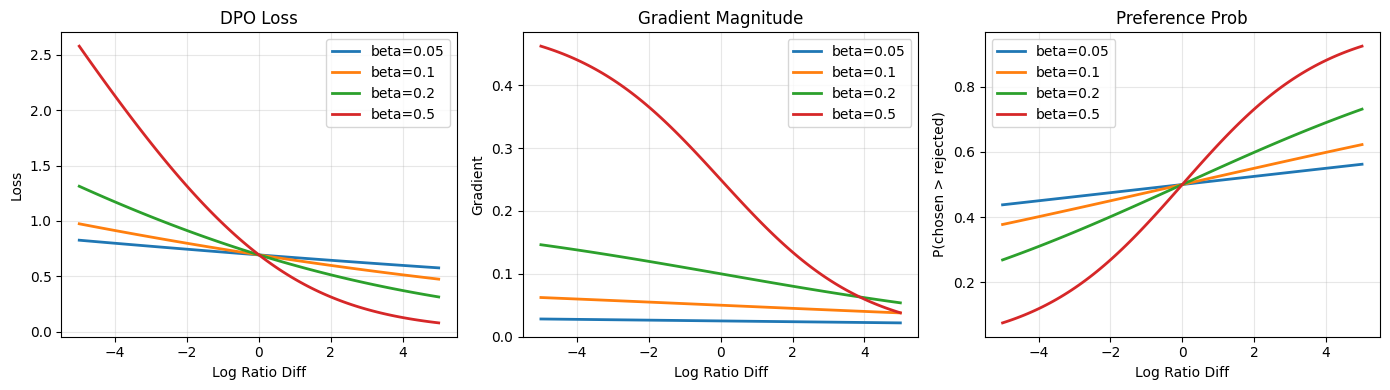

In [38]:
# 可视化 DPO 损失
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
log_ratio_diff = np.linspace(-5, 5, 100)

for beta in [0.05, 0.1, 0.2, 0.5]:
    loss = -np.log(1 / (1 + np.exp(-beta * log_ratio_diff)))
    axes[0].plot(log_ratio_diff, loss, label=f'beta={beta}', linewidth=2)
axes[0].set_xlabel('Log Ratio Diff'); axes[0].set_ylabel('Loss'); axes[0].set_title('DPO Loss'); axes[0].legend(); axes[0].grid(True, alpha=0.3)

for beta in [0.05, 0.1, 0.2, 0.5]:
    grad = beta * (1 / (1 + np.exp(beta * log_ratio_diff)))
    axes[1].plot(log_ratio_diff, grad, label=f'beta={beta}', linewidth=2)
axes[1].set_xlabel('Log Ratio Diff'); axes[1].set_ylabel('Gradient'); axes[1].set_title('Gradient Magnitude'); axes[1].legend(); axes[1].grid(True, alpha=0.3)

for beta in [0.05, 0.1, 0.2, 0.5]:
    prob = 1 / (1 + np.exp(-beta * log_ratio_diff))
    axes[2].plot(log_ratio_diff, prob, label=f'beta={beta}', linewidth=2)
axes[2].set_xlabel('Log Ratio Diff'); axes[2].set_ylabel('P(chosen > rejected)'); axes[2].set_title('Preference Prob'); axes[2].legend(); axes[2].grid(True, alpha=0.3)

plt.tight_layout(); plt.show()

## Part 3: 加载模型

我们准备两个模型：
- **policy_model**：需要优化的策略模型
- **reference_model**：冻结的参考模型，用于 KL 约束

为节省显存，本例仅训练最后几层 + lm_head，但足以看到风格偏好变化。

In [39]:
MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"
MAX_SEQ_LEN = 256

if device == 'cuda':
    DPO_BETA, DPO_LR, DPO_BATCH_SIZE, DPO_EPOCHS = 0.1, 5e-6, 4, 3
else:
    DPO_BETA, DPO_LR, DPO_BATCH_SIZE, DPO_EPOCHS = 0.1, 2e-6, 2, 2

TRAINABLE_LAYERS = 4
print(f"Config: beta={DPO_BETA}, lr={DPO_LR}, batch={DPO_BATCH_SIZE}, epochs={DPO_EPOCHS}")

Config: beta=0.1, lr=5e-06, batch=4, epochs=3


In [40]:
print(f"Loading {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

dtype = torch.bfloat16 if device == 'cuda' else torch.float32
policy_model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=dtype, trust_remote_code=True).to(device)
reference_model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=dtype, trust_remote_code=True).to(device)

reference_model.eval()
for p in reference_model.parameters(): p.requires_grad = False

for p in policy_model.parameters(): p.requires_grad = False
for layer in policy_model.model.layers[-TRAINABLE_LAYERS:]:
    for p in layer.parameters(): p.requires_grad = True
for p in policy_model.lm_head.parameters(): p.requires_grad = True

trainable = sum(p.numel() for p in policy_model.parameters() if p.requires_grad)
total = sum(p.numel() for p in policy_model.parameters())
print(f"Loaded: {total:,} params, {trainable:,} trainable ({trainable/total*100:.1f}%)")

Loading Qwen/Qwen2.5-0.5B-Instruct...
Loaded: 494,032,768 params, 195,784,192 trainable (39.6%)


In [41]:
def build_chat_prompt(msg): return tokenizer.apply_chat_template([{"role": "user", "content": msg}], tokenize=False, add_generation_prompt=True)
def build_full_text(msg, resp): return tokenizer.apply_chat_template([{"role": "user", "content": msg}, {"role": "assistant", "content": resp}], tokenize=False, add_generation_prompt=False)
def tokenize_text(text, max_length=MAX_SEQ_LEN, padding='max_length'): return tokenizer(text, max_length=max_length, padding=padding, truncation=True, return_tensors='pt')

@torch.inference_mode()
def generate_response(model, prompt, max_new_tokens=100, temperature=0.0):
    inputs = tokenize_text(build_chat_prompt(prompt), padding=False).to(device)
    outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, temperature=temperature if temperature > 0 else None, do_sample=temperature > 0, pad_token_id=tokenizer.pad_token_id)
    return tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True).strip()

print("Test generation:")
print(f"Q: 中国的首都是哪里？\nA: {generate_response(reference_model, '中国的首都是哪里？')}")

Test generation:
Q: 中国的首都是哪里？
A: 中国共有34个省级行政区，其中直辖市有2个：北京、上海；省会城市有10个：北京、天津、重庆、沈阳、大连、武汉、广州、成都、杭州和南京。所以，中国的首都是北京。


## Part 4: DPO 训练

训练步骤：
1. 计算 chosen/rejected 的 log-prob（只统计回复部分，避免 prompt 干扰）
2. 与 reference 计算 log-ratio 差
3. 用 DPO loss 更新 policy

监控指标：
- Loss：优化目标
- Reward margin：chosen 与 rejected 的差距
- Preference accuracy：chosen log-ratio > rejected 的比例

In [42]:
class DPODataset(Dataset):
    def __init__(self, data, tokenizer, max_length=MAX_SEQ_LEN):
        self.data, self.tokenizer, self.max_length = data, tokenizer, max_length
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        item = self.data[idx]
        prompt_tokens = tokenize_text(build_chat_prompt(item['prompt']), padding=False)
        chosen_tokens = tokenize_text(build_full_text(item['prompt'], item['chosen']), padding='max_length')
        rejected_tokens = tokenize_text(build_full_text(item['prompt'], item['rejected']), padding='max_length')
        return {'prompt_length': prompt_tokens['input_ids'].shape[1],
                'chosen_input_ids': chosen_tokens['input_ids'].squeeze(0), 'chosen_attention_mask': chosen_tokens['attention_mask'].squeeze(0),
                'rejected_input_ids': rejected_tokens['input_ids'].squeeze(0), 'rejected_attention_mask': rejected_tokens['attention_mask'].squeeze(0)}

train_dataset = DPODataset(PREFERENCE_DATA, tokenizer)
print(f"Dataset: {len(train_dataset)} examples")

Dataset: 30 examples


In [43]:
def compute_log_probs(model, input_ids, attention_mask, prompt_lengths, reduction="mean"):
    with torch.set_grad_enabled(model.training):
        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        shift_logits, shift_labels, shift_mask = logits[:, :-1, :], input_ids[:, 1:], attention_mask[:, 1:]
        log_probs = F.log_softmax(shift_logits.float(), dim=-1)
        token_log_probs = torch.gather(log_probs, dim=-1, index=shift_labels.unsqueeze(-1)).squeeze(-1)
        
        if not torch.is_tensor(prompt_lengths): prompt_lengths = torch.tensor(prompt_lengths)
        prompt_lengths = prompt_lengths.to(shift_mask.device)
        if prompt_lengths.dim() == 0: prompt_lengths = prompt_lengths.unsqueeze(0)
        
        seq_pos = torch.arange(shift_mask.size(1), device=shift_mask.device).unsqueeze(0)
        response_mask = (shift_mask * (seq_pos >= (prompt_lengths - 1).clamp(min=0).unsqueeze(1))).float()
        
        sum_log_probs = (token_log_probs * response_mask).sum(dim=-1)
        return sum_log_probs / response_mask.sum(dim=-1).clamp(min=1) if reduction == "mean" else sum_log_probs

In [44]:
class DPOTrainer:
    def __init__(self, policy_model, reference_model, beta=0.1, lr=1e-5):
        self.policy_model, self.reference_model, self.beta = policy_model, reference_model, beta
        self.optimizer = torch.optim.AdamW([p for p in policy_model.parameters() if p.requires_grad], lr=lr, weight_decay=0.01)
        self.history = {'loss': [], 'reward_margin': [], 'accuracy': []}
    
    def train_step(self, batch):
        self.policy_model.train()
        chosen_ids, chosen_mask = batch['chosen_input_ids'].to(device), batch['chosen_attention_mask'].to(device)
        rejected_ids, rejected_mask = batch['rejected_input_ids'].to(device), batch['rejected_attention_mask'].to(device)
        prompt_lengths = batch['prompt_length'].to(device)
        
        policy_chosen = compute_log_probs(self.policy_model, chosen_ids, chosen_mask, prompt_lengths)
        policy_rejected = compute_log_probs(self.policy_model, rejected_ids, rejected_mask, prompt_lengths)
        with torch.no_grad():
            ref_chosen = compute_log_probs(self.reference_model, chosen_ids, chosen_mask, prompt_lengths)
            ref_rejected = compute_log_probs(self.reference_model, rejected_ids, rejected_mask, prompt_lengths)
        
        loss, metrics = dpo_loss(policy_chosen, policy_rejected, ref_chosen, ref_rejected, self.beta)
        self.optimizer.zero_grad(); loss.backward(); torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), 1.0); self.optimizer.step()
        for k in self.history: self.history[k].append(metrics.get(k, 0))
        return metrics
    
    def train(self, dataset, batch_size=4, num_epochs=3, log_interval=5):
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        print(f"\n{'='*50}\nDPO Training: {len(dataset)} examples, {num_epochs} epochs\n{'='*50}")
        step = 0
        for epoch in range(num_epochs):
            for batch in loader:
                metrics = self.train_step(batch)
                step += 1
                if step % log_interval == 0:
                    print(f"Step {step:3d} | Loss: {metrics['loss']:.4f} | Margin: {metrics['reward_margin']:.4f} | Acc: {metrics['accuracy']:.2%}")
            print(f"Epoch {epoch+1}/{num_epochs} done\n{'-'*50}")
        print("Training completed!")

In [45]:
trainer = DPOTrainer(policy_model, reference_model, beta=DPO_BETA, lr=DPO_LR)
trainer.train(train_dataset, batch_size=DPO_BATCH_SIZE, num_epochs=DPO_EPOCHS, log_interval=5)


DPO Training: 30 examples, 3 epochs
Step   5 | Loss: 0.6907 | Margin: 0.0495 | Acc: 100.00%
Epoch 1/3 done
--------------------------------------------------
Step  10 | Loss: 0.6897 | Margin: 0.0682 | Acc: 100.00%
Step  15 | Loss: 0.6850 | Margin: 0.1645 | Acc: 100.00%
Epoch 2/3 done
--------------------------------------------------
Step  20 | Loss: 0.6843 | Margin: 0.1771 | Acc: 100.00%
Epoch 3/3 done
--------------------------------------------------
Training completed!


In [ ]:
import os

output_dir = os.path.join("models", "dpo_custom")
os.makedirs(output_dir, exist_ok=True)
policy_model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Saved DPO model to {output_dir}")

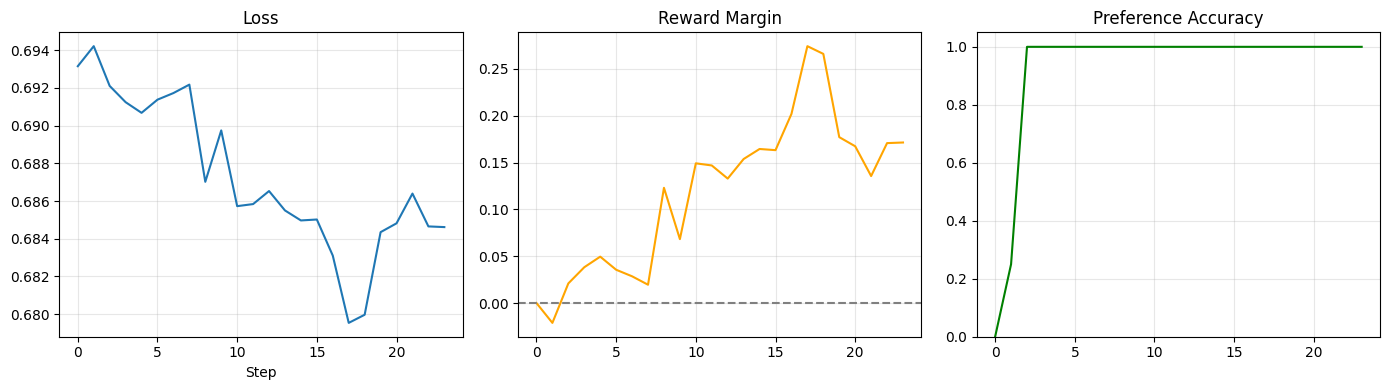

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].plot(trainer.history['loss']); axes[0].set_title('Loss'); axes[0].set_xlabel('Step'); axes[0].grid(True, alpha=0.3)
axes[1].plot(trainer.history['reward_margin'], color='orange'); axes[1].set_title('Reward Margin'); axes[1].axhline(y=0, color='gray', linestyle='--'); axes[1].grid(True, alpha=0.3)
axes[2].plot(trainer.history['accuracy'], color='green'); axes[2].set_title('Preference Accuracy'); axes[2].set_ylim([0, 1.05]); axes[2].grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

## Part 5: 效果评估 - 训练前后对比

对比 reference 与 DPO 模型：
- 生成长度变化（风格偏好强度）
- 偏好胜率（chosen 是否更可能）

如有独立测试集，可在泛化问题上复查效果。

In [47]:
TEST_QUESTIONS = [
    "中国的首都是哪里？", "什么是机器学习？", "Python中如何创建空列表？",  # 训练集内
    "日本的首都是哪里？", "什么是深度学习？", "如何定义Python函数？", "HTTP是什么？", "什么是变量？"  # 泛化
]

print("="*70 + "\nReference vs DPO Model\n" + "="*70)
ref_lens, dpo_lens = [], []
policy_model.eval()

for q in TEST_QUESTIONS:
    ref_resp = generate_response(reference_model, q)
    dpo_resp = generate_response(policy_model, q)
    ref_lens.append(len(ref_resp)); dpo_lens.append(len(dpo_resp))
    print(f"\n[Q] {q}\n[Ref] ({len(ref_resp)}字) {ref_resp}\n[DPO] ({len(dpo_resp)}字) {dpo_resp}\n" + "-"*70)

Reference vs DPO Model

[Q] 中国的首都是哪里？
[Ref] (79字) 中国共有34个省级行政区，其中直辖市有2个：北京、上海；省会城市有10个：北京、天津、重庆、沈阳、大连、武汉、广州、成都、杭州和南京。所以，中国的首都是北京。
[DPO] (172字) 中国共有34个省级行政区，分别是：北京市、天津市、上海市、浙江省、福建省、山东省、河南省、湖北省、湖南省、广东省、四川省、贵州省、云南省、西藏自治区、陕西省、甘肃省、青海省、宁夏回族自治区、新疆维吾尔自治区。其中，北京市是中华人民共和国的首都，位于中国东部，北依太行山脉，南临黄海，西与河北、天津相邻，东濒渤海，是中国的政治、经济、文化、交通和
----------------------------------------------------------------------

[Q] 什么是机器学习？
[Ref] (184字) 机器学习是一种人工智能的分支，它使计算机能够通过数据自动改进和优化其性能。简单来说，机器学习就是让计算机从数据中学习并从中做出决策或预测。

在机器学习中，算法被设计成可以从大量数据中提取模式，并使用这些模式来预测新的输入结果。这通常涉及到训练模型以识别模式、分类、回归等任务。机器学习的目标是让计算机能够在没有明确编程的情况下进行自我学习和适应。

机器学习技术广泛
[DPO] (182字) 机器学习是一种人工智能的分支，它使计算机能够通过数据自动改进和优化其性能。简单来说，就是让计算机“学会”如何从经验中学习并做出决策。

在机器学习中，算法被设计成可以从大量的、未标记的数据集中学习到模式，并根据这些模式进行预测或分类任务。这通常涉及以下几个步骤：

1. **数据收集**：收集包含大量训练样本的数据集。
2. **特征选择**：确定哪些特征对目标
----------------------------------------------------------------------

[Q] Python中如何创建空列表？
[Ref] (223字) 在 Python 中，你可以使用 `[]` 来创建一个空的列表。以下是一些示例：

1. 创建一个包含两个元素的空列表：
```python
my_list = []
print(my_list)
`


量化对比
Reference: 平均 153.9 字符 (min=9, max=223)
DPO Model: 平均 163.1 字符 (min=9, max=235)

长度减少: -6.0%


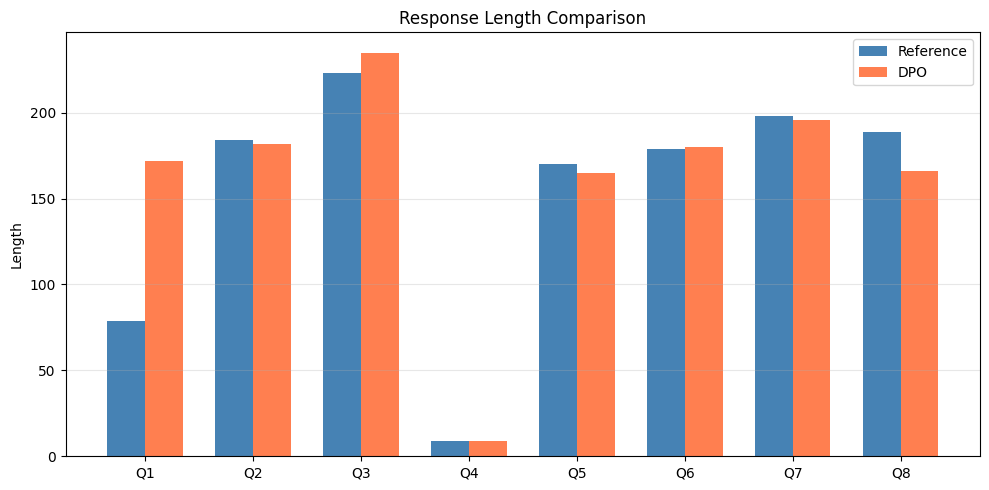

In [48]:
print("\n" + "="*50 + "\n量化对比\n" + "="*50)
print(f"Reference: 平均 {np.mean(ref_lens):.1f} 字符 (min={min(ref_lens)}, max={max(ref_lens)})")
print(f"DPO Model: 平均 {np.mean(dpo_lens):.1f} 字符 (min={min(dpo_lens)}, max={max(dpo_lens)})")
print(f"\n长度减少: {(np.mean(ref_lens)-np.mean(dpo_lens))/np.mean(ref_lens)*100:.1f}%")

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(TEST_QUESTIONS)); w = 0.35
ax.bar(x - w/2, ref_lens, w, label='Reference', color='steelblue')
ax.bar(x + w/2, dpo_lens, w, label='DPO', color='coral')
ax.set_ylabel('Length'); ax.set_title('Response Length Comparison'); ax.set_xticks(x); ax.set_xticklabels([f'Q{i+1}' for i in range(len(TEST_QUESTIONS))])
ax.legend(); ax.grid(True, alpha=0.3, axis='y'); plt.tight_layout(); plt.show()

In [49]:
def eval_pref_acc(model, dataset):
    model.eval()
    wins = 0
    for i in range(len(dataset)):
        b = dataset[i]
        with torch.no_grad():
            c = compute_log_probs(model, b['chosen_input_ids'].unsqueeze(0).to(device), b['chosen_attention_mask'].unsqueeze(0).to(device), b['prompt_length'])
            r = compute_log_probs(model, b['rejected_input_ids'].unsqueeze(0).to(device), b['rejected_attention_mask'].unsqueeze(0).to(device), b['prompt_length'])
        if c > r: wins += 1
    return wins / len(dataset)

ref_acc = eval_pref_acc(reference_model, train_dataset)
dpo_acc = eval_pref_acc(policy_model, train_dataset)
print(f"\nPreference Accuracy (简洁>冗长):")
print(f"  Reference: {ref_acc*100:.1f}%")
print(f"  DPO Model: {dpo_acc*100:.1f}%")
print(f"  提升: {(dpo_acc-ref_acc)*100:+.1f}%")


Preference Accuracy (简洁>冗长):
  Reference: 16.7%
  DPO Model: 23.3%
  提升: +6.7%


## Part 6: 生产级实现（TRL DPOTrainer）

TRL 提供开箱即用的 DPOTrainer，适合大规模训练与日志管理。
下面给出最小示例（需要安装 `trl` 和 `datasets`）。

In [50]:
# 生产级 DPOTrainer（可选）
try:
    from trl import DPOTrainer, DPOConfig
    from datasets import Dataset
    import inspect
    import os
    TRL_AVAILABLE = True
except ImportError:
    TRL_AVAILABLE = False

if TRL_AVAILABLE:
    def format_for_dpo(example):
        return {
            "prompt": example["prompt"],
            "chosen": example["chosen"],
            "rejected": example["rejected"],
        }

    dataset = Dataset.from_list([format_for_dpo(ex) for ex in PREFERENCE_DATA])

    output_dir = os.path.join("models", "dpo_output")
    os.makedirs(output_dir, exist_ok=True)

    dpo_config = DPOConfig(
        beta=0.1,
        output_dir=output_dir,
        num_train_epochs=3,
        per_device_train_batch_size=4,
        learning_rate=5e-6,
        logging_steps=10,
    )

    trainer_kwargs = dict(
        model=policy_model,
        ref_model=reference_model,
        args=dpo_config,
        train_dataset=dataset,
    )

    sig = inspect.signature(DPOTrainer.__init__)
    if "tokenizer" in sig.parameters:
        trainer_kwargs["tokenizer"] = tokenizer
    elif "processing_class" in sig.parameters:
        trainer_kwargs["processing_class"] = tokenizer

    trainer = DPOTrainer(**trainer_kwargs)
    trainer.train()
else:
    print("TRL not available. Install with: pip install trl datasets")

Extracting prompt in train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Step,Training Loss
10,0.538700
20,0.489200


## 总结

1. **偏好学习**：用 chosen/rejected 直接塑形模型输出
2. **RLHF vs DPO**：DPO 用偏好对替代奖励模型 + PPO，训练更稳更轻
3. **DPO 数学**：log-ratio 差决定偏好方向，$\beta$ 控制强度
4. **实现要点**：policy/ref 双模型、只计算回复 log-prob、监控 margin/acc

### 关键公式
- DPO Loss：
$$-\mathbb{E}[\log \sigma(\beta (\log \frac{\pi_\theta(y_w|x)}{\pi_{ref}(y_w|x)} - \log \frac{\pi_\theta(y_l|x)}{\pi_{ref}(y_l|x)}))]$$
- 隐式奖励：
$$r(x,y) = \beta \log \frac{\pi_\theta(y|x)}{\pi_{ref}(y|x)}$$

### DPO 优势
- 无需奖励模型
- 无需 on-policy 采样（PPO）
- 训练稳定、实现简单

## 练习

1. **Beta 调参**：尝试 0.01 / 0.1 / 0.5 观察风格强度变化
2. **扩展偏好对**：加入更多风格或内容偏好样本
3. **评估指标**：在独立测试集计算 win-rate
4. **Label smoothing**：为偏好标签加软化，观察训练稳定性